In [2]:
import sys
sys.path.append('..')
from economic_brazil.coleta_dados.economic_data_brazil import data_economic
from economic_brazil.processando_dados.divisao_treino_teste import treino_teste_seies_temporal
from economic_brazil.processando_dados.tratando_dados import TratandoDados
from economic_brazil.treinamento.treinamento_algoritimos import TreinandoModelos, carregar
from economic_brazil.analisando_modelos.analise_modelos_regressao import MetricasModelos
from economic_brazil.analisando_modelos.importancia_carecteristicas import ImportanciaShap, ImportanciaRandomForest
from economic_brazil.analisando_modelos.regressao_conformal import ConformalRegressionPlotter, ConformalAvaliandoMetodo
from economic_brazil.treinamento.redes_neurais_recorrentes import RnnModel
from economic_brazil.analisando_modelos.analise_modelos_regressao import MetricasModelos,MetricasModelosDicionario,PredicaosModelos
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

2024-05-28 19:44:30.421433: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-28 19:44:30.460648: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-28 19:44:30.908686: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-28 19:44:32.867770: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-28 19:44:46.179013: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF

In [3]:
dados = data_economic()

In [4]:
from economic_brazil.predicao_valores_futuros import KerasTrainedRegressor

In [5]:
data_inicio = dados[-50:].index[1].strftime('%Y-%m-%d')
print('Data divisao de treino e teste:',data_inicio)

Data divisao de treino e teste: 2020-05-01


In [6]:
tratando = TratandoDados(dados)
x_treino, x_teste, y_treino, y_teste,pca, scaler = tratando.tratando_dados()
data_divisao_treino_teste = tratando.data_divisao_treino_teste()
#temporal_teste = treino_teste_seies_temporal(x_teste, y_teste)


Data divisao de treino e teste: 2020-05-01
O tamanho do treino e  (244, 17)
O tamanho do teste e  (49, 17)
Data divisao de treino e teste: 2020-05-01


In [7]:
x_treino.shape, y_treino.shape, x_teste.shape, y_teste.shape

((239, 6), (239,), (44, 6), (44,))

In [8]:
modelos_carregados = carregar(diretorio='../codigos_rodando/modelos_salvos/',gradiente_boosting=True, xg_boost=True, cat_boost=True, regressao_linear=True, redes_neurais=True, sarimax=False)
modelos_carregados

{'gradiente_boosting': GradientBoostingRegressor(learning_rate=0.01, max_depth=9, n_estimators=500,
                           random_state=0),
 'xg_boost': XGBRegressor(base_score='1.2846597E1', booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...),
 'cat_boost': <catboost.core.CatBoostRegressor at 0x7f36a5732230>,
 'reg

In [9]:
predi = PredicaosModelos(modelos_carregados, x_treino, y_treino, x_teste, y_teste,)
predicoes_treino, predicoes_teste = predi.predicoes()
x_treino, y_treino, x_teste, y_teste, x_treino_recorrente, y_treino_recorrente, x_teste_recorrente, y_teste_recorrente = predi.return_dados()


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


In [25]:
'redes_neurais' in predicoes_teste.keys() 

True

In [10]:
metri = MetricasModelosDicionario()
metrica_teste = metri.calculando_metricas(predicoes_teste, y_teste, y_teste_recorrente)
metrica_treino = metri.calculando_metricas(predicoes_treino, y_treino, y_treino_recorrente)

In [11]:
metrica_teste.to_csv("/workspaces/Predicoes_macroeconomicas/codigos_rodando/avaliacao_modelos/metricas_teste.csv")
metrica_treino.to_csv("/workspaces/Predicoes_macroeconomicas/codigos_rodando/avaliacao_modelos/metricas_treino.csv")

In [12]:
index_treino = dados[dados.index <= data_divisao_treino_teste][6:].index
index_teste = dados[dados.index > data_divisao_treino_teste][4:].index

In [13]:
metri.plotando_predicoes(
    y_treino,
    predicoes_treino,
    index=index_treino,
    title="Predições nos dados de treino",
    save=True,
    diretorio='/workspaces/Predicoes_macroeconomicas/codigos_rodando/avaliacao_modelos/predicao_treino'
)

In [14]:
metri.plotando_predicoes(
    y_teste,
    predicoes_teste,
    index=index_teste,
    title="Predições nos dados de teste",
    save=True,
    diretorio='/workspaces/Predicoes_macroeconomicas/codigos_rodando/avaliacao_modelos/predicao_teste'
)

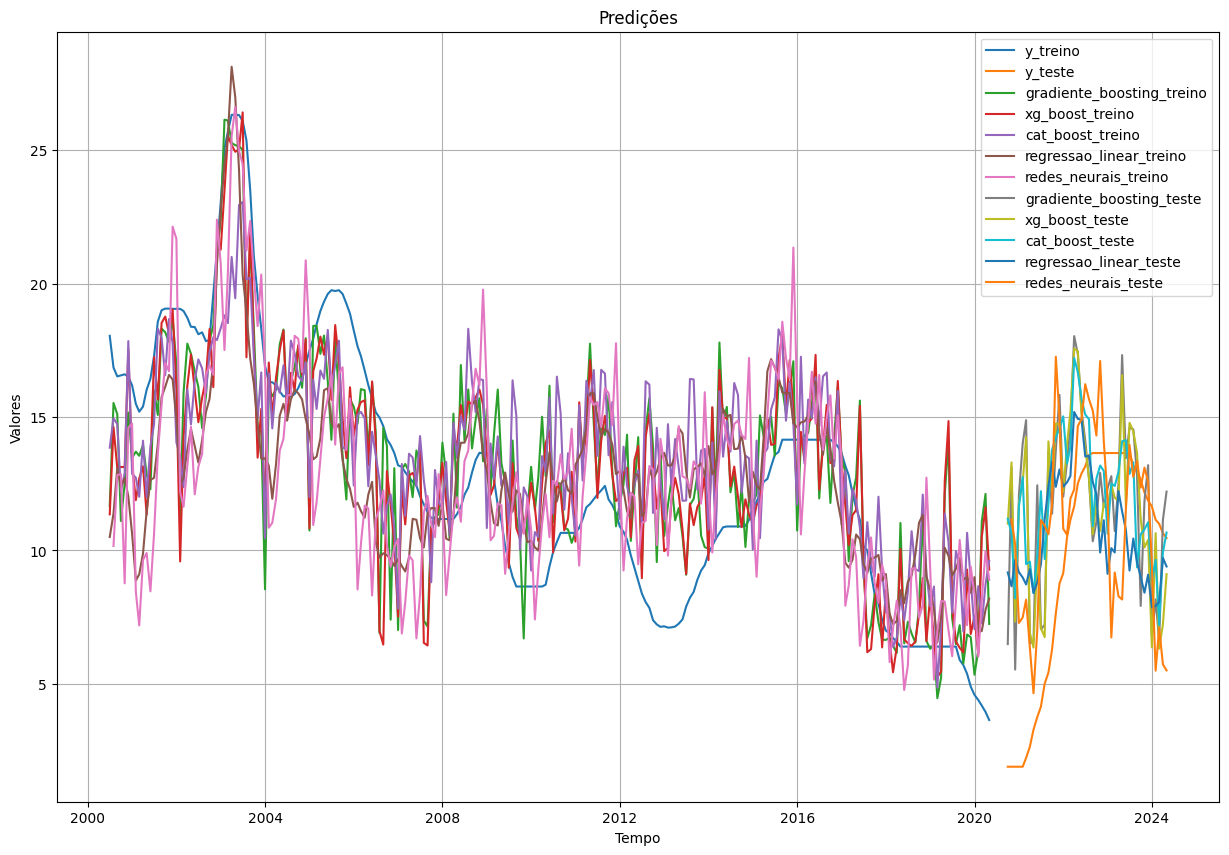

In [15]:
metri.plotando_predicoes_treino_teste(
    y_treino,
    y_teste,
    predicoes_treino,
    predicoes_teste,
    index_treino,
    index_teste,
)

In [16]:
metri.plotando_predicoes_go_treino_teste(
    y_treino,
    y_teste,
    predicoes_treino,
    predicoes_teste,
    index_treino,
    index_teste,
    save=True,
    diretorio='/workspaces/Predicoes_macroeconomicas/codigos_rodando/avaliacao_modelos/predicao_treino_teste.png',
    type_arquivo='png'
)

In [17]:
melhor_modelo = metrica_teste['MAE'].idxmin()
print(f'Melhor modelo baseado na MAE mais baixo, com valor de {metrica_teste["MAE"].min()}:',melhor_modelo)

Melhor modelo baseado na MAE mais baixo, com valor de 3.52: redes_neurais


# Regressão Conformal

In [18]:
index_treino_conformal = dados[dados.index <= data_divisao_treino_teste].index
index_teste_conformal = dados[dados.index > data_divisao_treino_teste].index

In [19]:
index_treino_conformal.shape,index_treino.shape

((245,), (239,))

In [20]:
from sklearn.base import BaseEstimator, RegressorMixin

# Criar uma classe de wrapper personalizado para o modelo Keras treinado
class KerasTrainedRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, model):
        self.model = model
        
    def fit(self, X, y):
        # Este método não será chamado, pois o modelo já está treinado
        pass
    
    def predict(self, X):
        return self.model.predict(X).squeeze()


In [21]:
conformal = ConformalRegressionPlotter(KerasTrainedRegressor(modelos_carregados[melhor_modelo]), x_treino_recorrente, x_teste_recorrente, y_treino[1:], y_teste[1:])
y_pred_neurais, y_pis_neurais, _,_ = conformal.regressao_conformal()
conformal.plot_prediction_intervals(index_train=index_treino_conformal, index_test=index_teste_conformal,title=f'Predição Intervals {melhor_modelo}',save=True,diretorio='/workspaces/Predicoes_macroeconomicas/codigos_rodando/avaliacao_modelos/regressao_conforma_teste.png')

2024-05-28 19:46:46.704554: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-28 19:46:46.704624: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-28 19:46:46.738466: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-28 19:46:46.745984: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-28 19:46:46.748328: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GP

In [ ]:
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, RegressorMixin
import plotly.graph_objects as go
import plotly.io as pio

# Criar uma classe de wrapper personalizado para o modelo Keras treinado
class KerasTrainedRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, model):
        self.model = model
        
    def fit(self, X, y):
        # Este método não será chamado, pois o modelo já está treinado
        pass
    
    def predict(self, X):
        return self.model.predict(X).squeeze()
    
class Predicao:
    def __init__(self, x_treino,y_treino, tratando_dados, modelo,modelo_carregado,):
        self.x_treino = x_treino
        self.y_treino = y_treino
        self.tratando_dados = tratando_dados
        self.modelo = modelo
        self.modelo_carregado = modelo_carregado
        self.neurais = RnnModel()
        self.mascara_sklearn = KerasTrainedRegressor()
        self.dados_predicao_futuro, self.dados_futuro, self.index_futuro = self.tratando_dados_futuros()
        self.x_treino_recorrente, self.y_treino_recorrente = self.neurais.create_dataset(self.x_treino, self.y_treino)
        
    def criando_dados_futuros(self,dados,coluna='selic'):
        dados_futuro = dados.iloc[-20:]
        new_index = dados.index[-1] + pd.DateOffset(months=1)
        dados_futuro.loc[new_index] = np.nan
        dados_futuro = dados_futuro.ffill()
        index_futuro = dados_futuro.index
        dados_predicao_futuro = self.tratando_dados.dados_futuros(dados_futuro)
        return dados_predicao_futuro, dados_futuro[coluna], index_futuro
    
    def tratando_dados_futuros(self,dados):
        if self.modelo == 'redes_neurais':
            dados_predicao_futuro, dados_futuro, index_futuro= self.criando_dados_futuros(dados)
            dados_recorrente, _ = self.neurais.create_dataset(dados_predicao_futuro, dados_futuro)
            return dados_predicao_futuro, dados_recorrente, index_futuro
        else:
            dados_predicao_futuro, dados_futuro, index_futuro = self.criando_dados_futuros(dados)
            return dados_predicao_futuro, dados_futuro, index_futuro
    
    def conformal_predicoes(self):
        if self.modelo == 'redes_neurais':
            conformal = ConformalRegressionPlotter(self.mascara_sklearn(self.modelo_carregado), self.x_treino_recorrente, self.dados_predicao_futuro, y_treino_recorrente[1:], self.dados_futuro[-9:])
            y_pred_best_model, y_pis_best_model, _,_ = conformal.regressao_conformal()
            return y_pred_best_model, y_pis_best_model, _,_
        else:
            conformal = ConformalRegressionPlotter(self.modelo_carregado, self.x_treino, self.dados_predicao_futuro, y_treino[1:], self.dados_futuro[-9:])
            y_pred_best_model, y_pis_best_model, _,_ = conformal.regressao_conformal()
            return y_pred_best_model, y_pis_best_model, _,_
    
    def criando_dataframe_predicoes(self):
        resultados_best = pd.DataFrame({'intervalo_lower': self.y_pis_best_model[:, 0, 0], 
                                'intervalo_upper':self.y_pis_best_model[:, 1, 0], 
                                'predicao': y_pred_neurais.squeeze()},
                                index=self.index_futuro[-9:])

        return resultados_best
    
    def plotando_predicoes(self):
        resultados_best = self.criando_dataframe_predicoes()
        fig = go.Figure()
        fig.add_trace(go.Scatter(x=resultados_best.index,y=resultados_best['predicao'],mode='lines',name='Predições'))
        fig.add_trace(
                    go.Scatter(
                        x=resultados_best.index,
                        y=resultados_best.intervalo_lower,
                        fill=None,
                        mode="lines",
                        line=dict(color="lightgrey"),
                        showlegend=False,
                    )
                )
        fig.add_trace(
            go.Scatter(
                x=resultados_best.index,
                y=resultados_best.intervalo_upper,
                fill="tonexty",
                mode="lines",
                line=dict(color="lightgrey"),
                showlegend=False,
                
            )
        )
        data_legenda = resultados_best.index[-1].strftime('%Y-%m-%d')
        fig.update_layout(title=f'Predições de {data_legenda}',xaxis_title='Anos',yaxis_title='Valores')
        fig.show()


In [ ]:
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, RegressorMixin
import plotly.graph_objects as go
import plotly.io as pio
class KerasTrainedRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, model):
        self.model = model
        
    def fit(self, X, y):
        # Este método não será chamado, pois o modelo já está treinado
        pass
    
    def predict(self, X):
        return self.model.predict(X).squeeze()


class Predicao:
    def __init__(self, x_treino, y_treino, tratando_dados,dados, modelo, modelo_carregado,coluna=None):
        self.x_treino = x_treino
        self.y_treino = y_treino
        self.tratando_dados = tratando_dados
        self.dados = dados
        self.modelo = modelo
        self.modelo_carregado = modelo_carregado
        self.coluna = coluna
        self.neurais = RnnModel()
        self.mascara_sklearn = KerasTrainedRegressor(self.modelo_carregado)
        self.x_treino_recorrente, self.y_treino_recorrente = self.neurais.create_dataset(self.x_treino, self.y_treino)
        self.dados_predicao_futuro, self.dados_futuro, self.index_futuro = self.tratando_dados_futuros()
        self.y_pred_best_model, self.y_pis_best_model, _, _ = self.conformal_predicoes()

    def criando_dados_futuros(self):
        dados_futuro = self.dados.iloc[-20:].copy()
        new_index = self.dados.index[-1] + pd.DateOffset(months=1)
        dados_futuro.loc[new_index] = np.nan
        dados_futuro = dados_futuro.ffill()
        index_futuro = dados_futuro.index
        dados_predicao_futuro = self.tratando_dados.dados_futuros(dados_futuro)
        return dados_predicao_futuro, dados_futuro[self.coluna].values, index_futuro

    def tratando_dados_futuros(self):
        if self.modelo == 'redes_neurais':
            dados_predicao_futuro, dados_futuro, index_futuro = self.criando_dados_futuros()
            dados_recorrente, _ = self.neurais.create_dataset(dados_predicao_futuro, dados_futuro)
            return dados_recorrente, dados_futuro, index_futuro
        else:
            dados_predicao_futuro, dados_futuro, index_futuro = self.criando_dados_futuros()
            return dados_predicao_futuro, dados_futuro, index_futuro

    def conformal_predicoes(self):
        if self.modelo == 'redes_neurais':
            conformal = ConformalRegressionPlotter(self.mascara_sklearn, self.x_treino_recorrente, self.dados_predicao_futuro[-9:], self.y_treino_recorrente, self.dados_futuro[-9:])
        else:
            conformal = ConformalRegressionPlotter(self.modelo_carregado, self.x_treino, self.dados_predicao_futuro, self.y_treino[1:], self.dados_futuro[-9:])
        
        y_pred_best_model, y_pis_best_model, _, _ = conformal.regressao_conformal()
        return y_pred_best_model, y_pis_best_model, _, _

    def criando_dataframe_predicoes(self):
        y_pis_best_model_squeezed = self.y_pis_best_model.squeeze()
        y_pred_best_model_squeezed = self.y_pred_best_model.squeeze()
        resultados_best = pd.DataFrame({
            'intervalo_lower': np.round(y_pis_best_model_squeezed[:, 0],2),
            'intervalo_upper': np.round(y_pis_best_model_squeezed[:, 1],2),
            'predicao': np.round(y_pred_best_model_squeezed,2)
        }, index=self.index_futuro[-9:])
        return resultados_best
    
    def predicao_ultimo_periodo(self):
        dados_predicao = self.criando_dataframe_predicoes()
        data = dados_predicao.index[-1].strftime('%Y-%m-%d')
        intervalo_lower = dados_predicao['intervalo_lower'][-1]
        intervalo_upper = dados_predicao['intervalo_upper'][-1]
        predicao_proximo_mes = dados_predicao['predicao'][-1]
        return data,intervalo_lower,intervalo_upper,predicao_proximo_mes

    def plotando_predicoes(self):
        resultados_best = self.criando_dataframe_predicoes()
        fig = go.Figure()
        fig.add_trace(go.Scatter(x=resultados_best.index, y=resultados_best['predicao'], mode='lines', name='Predições'))
        fig.add_trace(
            go.Scatter(
                x=resultados_best.index,
                y=resultados_best['intervalo_lower'],
                fill=None,
                mode="lines",
                line=dict(color="lightgrey"),
                showlegend=False,
            )
        )
        fig.add_trace(
            go.Scatter(
                x=resultados_best.index,
                y=resultados_best['intervalo_upper'],
                fill="tonexty",
                mode="lines",
                line=dict(color="lightgrey"),
                showlegend=False,
            )
        )
        data_legenda = resultados_best.index[-1].strftime('%Y-%m-%d')
        fig.update_layout(title=f'Predições de {data_legenda}', xaxis_title='Anos', yaxis_title='Valores')
        fig.show()


In [ ]:
predicao = Predicao(x_treino,y_treino,tratando,dados,melhor_modelo,modelos_carregados[melhor_modelo],coluna='selic')

2024-05-28 13:37:31.291021: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-28 13:37:31.291021: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-28 13:37:31.291131: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-28 13:37:31.291336: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly 

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 274ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 269ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 255ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 262ms/step


2024-05-28 13:38:06.419806: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-28 13:38:06.445630: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-28 13:38:06.451718: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-28 13:38:06.592003: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-28 13:38:16.108363: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 305ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
Coverage and prediction interval width mean for CV+: 1.000, 14.060


In [ ]:
dados_predicao_futuro, dados_futuro, index_futuro = predicao.criando_dados_futuros()

In [ ]:
#y_pred, y_pis,_,_ = predicao.conformal_predicoes()

In [ ]:
dados_predicao = predicao.criando_dataframe_predicoes()
dados_predicao

,intervalo_lower,intervalo_upper,predicao
Date,,,
2023-10-01,5.07,19.13,12.10
2023-11-01,5.86,19.92,12.89
2023-12-01,5.17,19.23,12.20
2024-01-01,2.10,16.16,9.13
2024-02-01,-1.36,12.70,5.67
2024-03-01,0.85,14.91,7.88
2024-04-01,-0.35,13.71,6.68
2024-05-01,-1.56,12.50,5.47
2024-06-01,3.27,17.33,10.30


In [ ]:
data_predicao,intervalo_lower,intervalo_upper,predicao_proximo_mes= predicao.predicao_ultimo_periodo()

In [ ]:
dados_futuro = {
    'data': data_predicao,
    'intervalo_lower': intervalo_lower,
    'intervalo_upper': intervalo_upper,
    'predicao': predicao_proximo_mes}

In [ ]:
predicoes_teste

NameError: name 'predicoes_teste' is not defined

In [ ]:
import pickle
with open('/workspaces/Predicoes_macroeconomicas/codigos_rodando/avaliacao_modelos/dados_futuro.pkl', 'wb') as pickle_file:
    pickle.dump(dados_futuro, pickle_file)

In [ ]:
with open('/workspaces/Predicoes_macroeconomicas/codigos_rodando/avaliacao_modelos/dados_futuro.pkl', 'rb') as pickle_file:
    dados_futuro_carregado = pickle.load(pickle_file)

In [ ]:
dados_futuro_carregado

{'data': '2024-06-01',
 'intervalo_lower': 3.27,
 'intervalo_upper': 17.33,
 'predicao': 10.3}

In [ ]:
dados_futuro

{'data': '2024-06-01',
 'intervalo_lower': 3.27,
 'intervalo_upper': 17.33,
 'predicao': 10.3}

In [ ]:
round(predicao_proximo_mes,2)

10.3

In [ ]:
print(f'Data da predição:{data_predicao}, Valor da predição:{predicao_proximo_mes}, Intervalo de predição [lower,upper] :{intervalo_lower,intervalo_upper}')

Data da predição:2024-06-01, Valor da predição:10.300000190734863, Intervalo de predição [lower,upper] :(3.27, 17.33)


In [ ]:
predicao.plotando_predicoes()

In [ ]:
def dados_futuros(dados,tratando_dados,coluna='selic'):
    dados_futuro = dados.iloc[-20:]
    #new_index = pd.to_datetime(data_futura)
    new_index = dados.index[-1] + pd.DateOffset(months=1)
    dados_futuro.loc[new_index] = np.nan
    dados_futuro = dados_futuro.ffill()
    index_futuro = dados_futuro.index
    dados_predicao_futuro = tratando_dados.dados_futuros(dados_futuro)
    return dados_predicao_futuro, dados_futuro[coluna], index_futuro
dados_predicao_futura,y_futuro,index_futuro = dados_futuros(dados,tratando)
dados_predicao_futura_recorrente,_ = RnnModel().create_dataset(dados_predicao_futura, y_futuro)

In [ ]:
conformal = ConformalRegressionPlotter(KerasTrainedRegressor(modelos_carregados['redes_neurais']), x_treino_recorrente, dados_predicao_futura_recorrente, y_treino[1:], y_futuro[-9:])
y_pred_best_model, y_pis_best_model, _,_ = conformal.regressao_conformal()
#conformal.plot_prediction_intervals(index_train=index_treino_conformal, index_test=index_teste_conformal,title='Predição Intervals Regressão XGBoost')

2024-05-24 12:41:11.752662: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-24 12:41:11.752693: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-24 12:41:11.752692: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-24 12:41:11.872833: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machi

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 658ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 663ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 665ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 640ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 622ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 516ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 655ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step
Coverage and prediction interval width mean for CV+: 1.000, 11.249


In [ ]:
y_pis_best_model.squeeze()[:, 1]

array([17.2308717 , 16.62957909, 15.73298599, 15.42390587, 12.09096624,
       11.76400902, 12.64355566, 16.02820351, 16.68590691])

In [ ]:
y_pis_best_model[:, 0, 0]

array([5.98201702, 5.38072441, 4.48413132, 4.17505119, 0.84211157,
       0.51515434, 1.39470098, 4.77934883, 5.43705223])

In [ ]:
resultados_best = pd.DataFrame({'intervalo_lower': y_pis_best_model[:, 0, 0], 
                                'intervalo_upper':y_pis_best_model[:, 1, 0], 
                                'predicao': y_pred_neurais.squeeze()},
                               index=index_futuro[-9:])

resultados_best


,intervalo_lower,intervalo_upper,predicao
Date,,,
2023-10-01,5.982017,17.230872,11.606444
2023-11-01,5.380724,16.629579,11.005152
2023-12-01,4.484131,15.732986,10.108559
2024-01-01,4.175051,15.423906,9.799479
2024-02-01,0.842112,12.090966,6.466539
2024-03-01,0.515154,11.764009,6.139582
2024-04-01,1.394701,12.643556,7.019128
2024-05-01,4.779349,16.028204,10.403776
2024-06-01,5.437052,16.685907,11.061480


# Predicao futuro

In [ ]:
import pandas as pd
import numpy as np
def dados_futuros(dados,tratando_dados,coluna='selic'):
    dados_futuro = dados.iloc[-20:]
    #new_index = pd.to_datetime(data_futura)
    new_index = dados.index[-1] + pd.DateOffset(months=1)
    dados_futuro.loc[new_index] = np.nan
    dados_futuro = dados_futuro.ffill()
    index_futuro = dados_futuro.index
    dados_predicao_futuro = tratando_dados.dados_futuros(dados_futuro)
    return dados_predicao_futuro, dados_futuro[coluna], index_futuro

In [ ]:
dados_predicao_futura,y_futuro,index_futuro = dados_futuros(dados,tratando)
dados_predicao_futura_recorrente,_ = RnnModel().create_dataset(dados_predicao_futura, y_futuro)

In [ ]:
dados_predicao_futura_recorrente,_ = RnnModel().create_dataset(dados_predicao_futura, y_futuro)

In [ ]:
futuro = predi.predicoes(predicao_futuro=True, dados_predicao=dados_predicao_futura, dados_predicao_recorrente=dados_predicao_futura_recorrente)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


In [ ]:
import plotly.graph_objects as go
import plotly.io as pio
fig = go.Figure()
fig.add_trace(go.Scatter(x=resultados_best.index,y=resultados_best['predicao'],mode='lines',name='Predições'))
fig.add_trace(
            go.Scatter(
                x=resultados_best.index,
                y=resultados_best.intervalo_lower,
                fill=None,
                mode="lines",
                line=dict(color="lightgrey"),
                showlegend=False,
            )
        )
fig.add_trace(
    go.Scatter(
        x=resultados_best.index,
        y=resultados_best.intervalo_upper,
        fill="tonexty",
        mode="lines",
        line=dict(color="lightgrey"),
        showlegend=False,
        
    )
)
data_legenda = resultados_best.index[-1].strftime('%Y-%m-%d')
fig.update_layout(title=f'Predições de {data_legenda}',xaxis_title='Anos',yaxis_title='Valores')
fig.show()
 